## Multi-grain indexation based on diagram simulation and matching-rate.

In [1]:
import functools
import math
import random
import timeit

from tqdm.autonotebook import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from laueimproc.geometry import *

/tmp/ipykernel_17360/975530036.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Reference constants and parameters
* `LATTICE` is the 3x2 matrix of the lattice parameter $[[a, b, c], [\alpha, \beta, \gamma]]$
* `PONI` are the detector parameters $[dist, poni_1, poni_2, rot_1, rot_2, rot_3]$

The incoming $ui$ ray is always $[0, 0, 1]$, according to the pyfai convention.

In [2]:
LATTICE = torch.tensor([3.6e-10, 3.6e-10, 3.6e-10, torch.pi/2, torch.pi/2, torch.pi/2])  # copper
PONI = torch.tensor([0.07, 73.4e-3, 73.4e-3, 0.0, -torch.pi/2, 0.0])  # mode laue detector on top
DETECTOR = {"shape": (2018, 2016), "pxl": 73.4e-6}
GNOM_PONI = torch.tensor([1.0, 0, 0, 0.0, -3*torch.pi/4, 0.0])
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Associate the functions

In [3]:
EV = 1.60e-19  # 1 eV = EV J

def lattice_to_reciprocal(lattice):
    primitive = lattice_to_primitive(lattice)
    reciprocal = primitive_to_reciprocal(primitive)
    return reciprocal

def hkl_reciprocal_rot_to_uq(hkl, reciprocal, rot):
    reciprocal_rotated = rotate_crystal(reciprocal, rot)
    u_q = hkl_reciprocal_to_uq(hkl, reciprocal_rotated)
    return u_q
    
def uq_poni_to_detector(u_q, poni):
    u_f = uq_to_uf(u_q)
    point, dist = ray_to_detector(u_f, poni)
    point = point[dist > 0, :]  # ray wrong direction => virtual intersection
    point = point[point[..., 0] > 0, :]  # out of detector top
    point = point[point[..., 0] < DETECTOR["shape"][0] * DETECTOR["pxl"], :]  # out of detector bottom
    point = point[point[..., 1] > 0, :]  # out of detector left
    point = point[point[..., 1] < DETECTOR["shape"][1] * DETECTOR["pxl"], :]  # out of detector right
    return point

def detector_poni_to_uq(point, poni):
    u_f = detector_to_ray(point, poni)
    u_q = uf_to_uq(u_f)
    return u_q

In [4]:
def full_simulation(hkl, lattice, rot, poni):
    reciprocal = lattice_to_reciprocal(lattice)
    u_q = hkl_reciprocal_rot_to_uq(hkl, reciprocal, rot)
    point = uq_poni_to_detector(u_q, poni)
    return point

### Use and associate the functions

#### Simulation of one random diagram

there are 1683 experimental spots


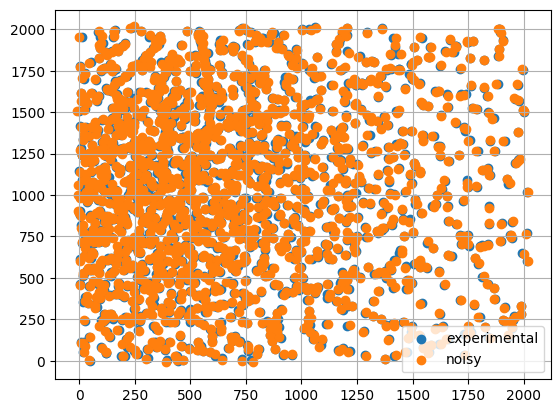

In [5]:
hkl = select_hkl(LATTICE, e_max=27e3*EV, keep_harmonics=False)
# rot = angle_to_rot(5*torch.pi/180, 0, 0, meshgrid=False)  # to simulate a single grain
rot = angle_to_rot(
    torch.pi * torch.rand(5), torch.pi * torch.rand(5), torch.pi * torch.rand(5), meshgrid=False
).reshape(-1, 3, 3)  # to simulate n grains

point = full_simulation(hkl, LATTICE, rot, PONI)
print(f"there are {len(point)} experimental spots")
point_exp = point + 5 * DETECTOR["pxl"] * torch.randn_like(point)  # add position noise
uq_exp = detector_poni_to_uq(point_exp, PONI)

plt.scatter(*(point / DETECTOR["pxl"]).movedim(-1, 0), label="experimental")
plt.scatter(*(point_exp / DETECTOR["pxl"]).movedim(-1, 0), label="noisy")
plt.legend()
plt.grid()
plt.show()

#### Simple Indexation

  0%|          | 0/1728 [00:00<?, ?it/s]

best matching rate 293


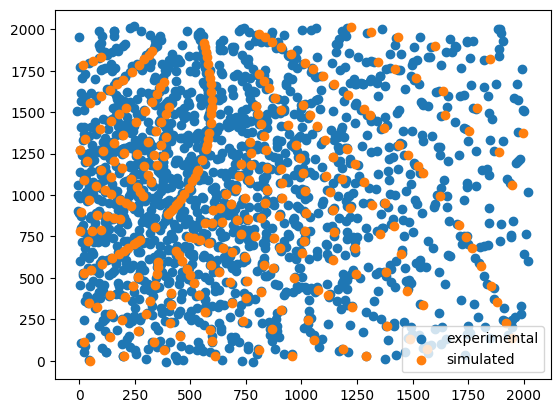

In [6]:
# preparation
ANGLE_RES = math.radians(0.75)
hkl = select_hkl(LATTICE, e_max=20e3*EV, keep_harmonics=False)
all_rot = angle_to_rot(
    torch.arange(0, torch.pi / 2.0, ANGLE_RES),
    torch.arange(0, torch.pi / 2.0, ANGLE_RES),
    torch.arange(0, torch.pi / 2.0, ANGLE_RES),
).reshape(-1, 3, 3)

compute_matching_rate_comp = torch.compile(compute_matching_rate, fullgraph=True, dynamic=False)
hkl_reciprocal_rot_to_uq_comp = torch.compile(hkl_reciprocal_rot_to_uq, fullgraph=True, dynamic=False)

# simulation
reciprocal = lattice_to_reciprocal(LATTICE)
uq_exp_shift = uq_exp.movedim(0, -2).contiguous()
rate = torch.empty(*torch.broadcast_shapes(uq_exp_shift.shape[:-2], all_rot.shape[:-2]))
for i in tqdm(range(0, len(all_rot), 1000)):
    uq_simul = hkl_reciprocal_rot_to_uq_comp(hkl, reciprocal, all_rot[i:i+1000])
    uq_simul = uq_simul.movedim(0, -2).contiguous()
    # rate[i:i+1000] = compute_matching_rate_comp(uq_exp_shift, uq_simul, phi_max=math.radians(0.5), _no_c=True)
    rate[i:i+1000] = compute_matching_rate(uq_exp_shift, uq_simul, phi_max=math.radians(0.5))
print(f"best matching rate {int(rate.max())}")

# plot result
point_simul = full_simulation(hkl, LATTICE, all_rot[rate.argmax()], PONI)
plt.scatter(*(point_exp / DETECTOR["pxl"]).movedim(-1, 0), label="experimental")
plt.scatter(*(point_simul / DETECTOR["pxl"]).movedim(-1, 0), label="simulated")
plt.legend()
plt.show()

tensor([293., 274., 274., 272., 270., 269., 268., 266., 264., 264.])


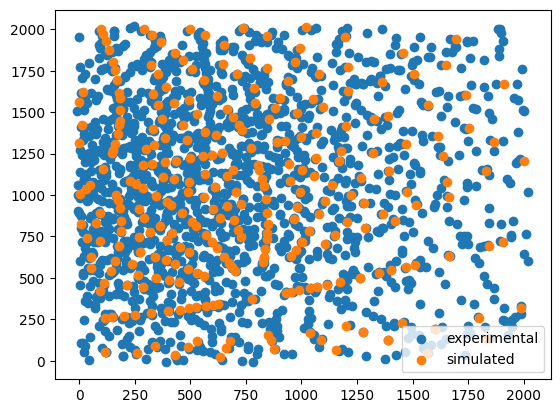

In [7]:
# print(all_rot[rate.argsort(descending=True)[1]])
# print(rot)
print(rate.sort(descending=True).values[:10])

point_simul = full_simulation(hkl, LATTICE, all_rot[rate.argsort(descending=True)[3]], PONI)
# plt.scatter(*(point / DETECTOR["pxl"]).movedim(-1, 0), label="simulated")
plt.scatter(*(point_exp / DETECTOR["pxl"]).movedim(-1, 0), label="experimental")
plt.scatter(*(point_simul / DETECTOR["pxl"]).movedim(-1, 0), label="simulated")
plt.legend()
plt.show()

#### Simple basic test and timing

In [8]:
# simple timing

BATCH = 100  # number of simulated diagrams
ROT = torch.eye(3)

# case float64
lattice, rot, poni = LATTICE.clone().to(torch.float64), ROT.clone().to(torch.float64), PONI.clone().to(torch.float64)
speed = min(timeit.repeat(lambda: full_simulation(hkl, lattice, rot, poni), repeat=10, number=BATCH)) / BATCH
print(f"float64: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32
lattice, rot, poni = LATTICE.clone().to(torch.float32), ROT.clone().to(torch.float32), PONI.clone().to(torch.float32)
speed = min(timeit.repeat(lambda: full_simulation(hkl, lattice, rot, poni), repeat=10, number=BATCH)) / BATCH
print(f"float32: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float64 batched
lattice, rot, poni = LATTICE.clone().to(torch.float64), ROT.clone().to(torch.float64), PONI.clone().to(torch.float64)
lattice = lattice[None, :].expand(BATCH, -1)
speed = min(timeit.repeat(lambda: full_simulation(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
print(f"float64 batched: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32 batched
lattice, rot, poni = LATTICE.clone().to(torch.float32), ROT.clone().to(torch.float32), PONI.clone().to(torch.float32)
lattice = lattice[None, :].expand(BATCH, -1)
speed = min(timeit.repeat(lambda: full_simulation(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
print(f"float32 batched: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float64 batched compiled
lattice, rot, poni = LATTICE.clone().to(torch.float64), ROT.clone().to(torch.float64), PONI.clone().to(torch.float64)
lattice = lattice[None, :].expand(BATCH, -1)
full_simulation_comp = torch.compile(full_simulation, dynamic=False)
speed = min(timeit.repeat(lambda: full_simulation_comp(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
print(f"float64 batched compiled: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

# case float32 batched compiled
lattice, rot, poni = LATTICE.clone().to(torch.float32), ROT.clone().to(torch.float32), PONI.clone().to(torch.float32)
lattice = lattice[None, :].expand(BATCH, -1)
full_simulation_comp = torch.compile(full_simulation, dynamic=False)
speed = min(timeit.repeat(lambda: full_simulation_comp(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
print(f"float32 batched compiled: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

if DEVICE.type == "cuda":
    # case float64 batched compiled gpu
    lattice, rot, poni = LATTICE.clone().to(dytpe=torch.float64, device=DEVICE), ROT.clone().to(dtype=torch.float64, device=DEVICE), PONI.clone().to(dytpe=torch.float64, device=DEVICE)
    lattice = lattice[None, :].expand(BATCH, -1)
    full_simulation_comp = torch.compile(full_simulation, dynamic=False)
    speed = min(timeit.repeat(lambda: full_simulation_comp(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
    print(f"float64 batched compiled gpu: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")
    
    # case float32 batched compiled gpu
    lattice, rot, poni = LATTICE.clone().to(dytpe=torch.float32, device=DEVICE), ROT.clone().to(dtype=torch.float32, device=DEVICE), PONI.clone().to(dytpe=torch.float32, device=DEVICE)
    lattice = lattice[None, :].expand(BATCH, -1)
    full_simulation_comp = torch.compile(full_simulation, dynamic=False)
    speed = min(timeit.repeat(lambda: full_simulation_comp(hkl, lattice, rot, poni), repeat=10, number=1)) / BATCH
    print(f"float32 batched compiled gpu: it takes {speed*1e6:.2f}us by simulation <=> {1.0/speed:.2f}Hz")

float64: it takes 4486.98us by simulation <=> 222.87Hz
float32: it takes 4357.67us by simulation <=> 229.48Hz
float64 batched: it takes 1000.84us by simulation <=> 999.16Hz
float32 batched: it takes 711.53us by simulation <=> 1405.41Hz
float64 batched compiled: it takes 799.35us by simulation <=> 1251.01Hz
float32 batched compiled: it takes 554.36us by simulation <=> 1803.87Hz


#### Propagation of positional uncertainty

Let $f$ be a derivable function such that $\tilde{y} = f(\tilde{x})$.<br>
Let $\epsilon$ be the uncertainty on the image such that $\tilde{y} = y + \epsilon$ and $\eta$ the uncertainty on the antecedent such that $\tilde{x} = x + \eta$.<br>

By definition, $\frac{df(x)}{dx} = \lim\limits_{\eta \to 0} \frac{f(x + \eta) - f(x)}{\eta}$


$\tilde{x} = x + \epsilon \Leftrightarrow \tilde{y} = f(x + \epsilon)$

### Projection gnomonic

In [9]:
def cam_to_gnom(cam_point: torch.Tensor, cam_poni: torch.Tensor, gnom_poni: torch.Tensor) -> torch.Tensor:
    """Project the camera point into the gnomonic space.

    Parameters
    ----------
    cam_point : torch.Tensor
        The projected ray uf on the detector. Transmitted to ``detector_to_ray``.
    cam_poni : torch.Tensor
        The real detector callibration parameters. Transmitted to ``detector_to_ray``.
    gnom_poni : torch.Tensor
        The virtual gnomonic detector position. Transmitted to ``ray_to_detector``.

    Returns
    -------
    gnom_point : torch.Tensor
        The projected ray uq on the virtual gnomonic detector.
    """
    u_f = dif.detector_to_ray(cam_point, cam_poni)
    u_q = dif.uf_to_uq(u_f)
    gnom_point, _ = dif.ray_to_detector(u_q, gnom_poni)
    return gnom_point


def gnom_to_cam(gnom_point: torch.Tensor, gnom_poni: torch.Tensor, cam_poni: torch.Tensor) -> torch.Tensor:
    """Project the camera point into the gnomonic space.

    Parameters
    ----------
    gnom_point : torch.Tensor
        The projected ray uq on the virtual gnomonic detector. Transmitted to ``detector_to_ray``.
    gnom_poni : torch.Tensor
        The virtual gnomonic detector position. Transmitted to ``ray_to_detector``.
    cam_poni : torch.Tensor
        The real detector callibration parameters. Transmitted to ``detector_to_ray``.

    Returns
    -------
    cam_point : torch.Tensor
        The projected ray uf on the detector.
    """
    u_q = dif.detector_to_ray(gnom_point, gnom_poni)
    u_f = dif.uq_to_uf(u_q)
    cam_point, _ = dif.ray_to_detector(u_f, cam_poni)
    return cam_point

#### Points projection

In [10]:
# create noisy diagram
cam_point = simulate(LATTICE, PONI)
exp_point = cam_point + torch.randn_like(cam_point) * (0.01 * cam_point.std())
gnom_point = cam_to_gnom(exp_point, PONI, GNOM_PONI)

plt.subplot(1, 2, 1)
plt.scatter(*(cam_point / DETECTOR["pxl"]).movedim(-1, 0))
plt.scatter(*(exp_point / DETECTOR["pxl"]).movedim(-1, 0), color="orange")
plt.subplot(1, 2, 2)
plt.scatter(*gnom_point.movedim(-1, 0))
plt.show()

NameError: name 'simulate' is not defined

#### Image projection

In [ ]:
# create a virtual image

from laueimproc.gmm.gmm import gmm2d

pixels = torch.meshgrid(torch.arange(DETECTOR["shape"][0]), torch.arange(DETECTOR["shape"][1]), indexing="ij")
pixels = torch.cat([p.ravel().unsqueeze(-1)for p in pixels], dim=1)  # shape (n, 2)
spots_pos = simulate(LATTICE, PONI) / DETECTOR["pxl"]  # shape (k, 2)
img = torch.zeros(DETECTOR["shape"]).ravel()
for i in tqdm(range(len(spots_pos))):
    img += gmm2d(pixels, spots_pos[i][None, :], 10.0*torch.eye(2)[None, :, :], torch.tensor(1.0)[None])
img = img.reshape(*DETECTOR["shape"])
img /= img.amax()

# to numpy
img_f32 = img.numpy(force=True)
img *= 65335
img + 0.5
img_u16 = img.numpy().astype(np.uint16)

plt.imshow(img_u16, cmap="plasma")
plt.show()

In [ ]:
# create map convertion for cv2

# forward for estimation of shape
i_max = DETECTOR["shape"][0] * DETECTOR["pxl"]
j_max = DETECTOR["shape"][1] * DETECTOR["pxl"]
cam = torch.tensor(
    [[0, 0], [i_max/2, 0], [i_max, 0], [i_max/2, j_max/2], [i_max/2, j_max], [i_max/2, j_max], [0, j_max], [0, j_max/2]]
)
gnom = cam_to_gnom(cam, PONI, GNOM_PONI)

# backward for interpolation
gnom_shape = DETECTOR["shape"]  # best shape diff
gnom = (
    torch.linspace(gnom[:, 0].amin(), gnom[:, 0].amax(), gnom_shape[0]),  
    torch.linspace(gnom[:, 1].amin(), gnom[:, 1].amax(), gnom_shape[1]),
)
gnom = torch.meshgrid(*gnom, indexing="ij")
gnom = torch.cat([g.ravel().unsqueeze(1) for g in gnom], dim=1)
cam = gnom_to_cam(gnom, GNOM_PONI, PONI)
cam /= DETECTOR["pxl"]

# to cv2 map
map1 = cam[..., 0].reshape(gnom_shape).numpy().astype(np.float32)
map2 = cam[..., 1].reshape(gnom_shape).numpy().astype(np.float32)

In [ ]:
# interpolation

# simple convertion
gnom_img = cv2.remap(img_u16, map2, map1, interpolation=cv2.INTER_LINEAR)
plt.imshow(gnom_img, cmap="plasma")
plt.show()

BATCH = 10

# case uint16 bilinear
speed = min(timeit.repeat(lambda: cv2.remap(img_u16, map2, map1, interpolation=cv2.INTER_LINEAR), repeat=10, number=BATCH)) / BATCH
print(f"uint16 bilinear: it takes {speed*1e3:.2f}ms by image")

# case uint16 bicubic
speed = min(timeit.repeat(lambda: cv2.remap(img_u16, map2, map1, interpolation=cv2.INTER_CUBIC), repeat=10, number=BATCH)) / BATCH
print(f"uint16 bicubic: it takes {speed*1e3:.2f}ms by image")

# case float32 bilinear
speed = min(timeit.repeat(lambda: cv2.remap(img_f32, map2, map1, interpolation=cv2.INTER_LINEAR), repeat=10, number=BATCH)) / BATCH
print(f"float32 bilinear: it takes {speed*1e3:.2f}ms by image")

# case float32 bicubic
speed = min(timeit.repeat(lambda: cv2.remap(img_f32, map2, map1, interpolation=cv2.INTER_CUBIC), repeat=10, number=BATCH)) / BATCH
print(f"float32 bicubic: it takes {speed*1e3:.2f}ms by image")